# Episodic Semi-Gradient Sarsa Tiling

Use a linear regresor with tiling to simplify the problem

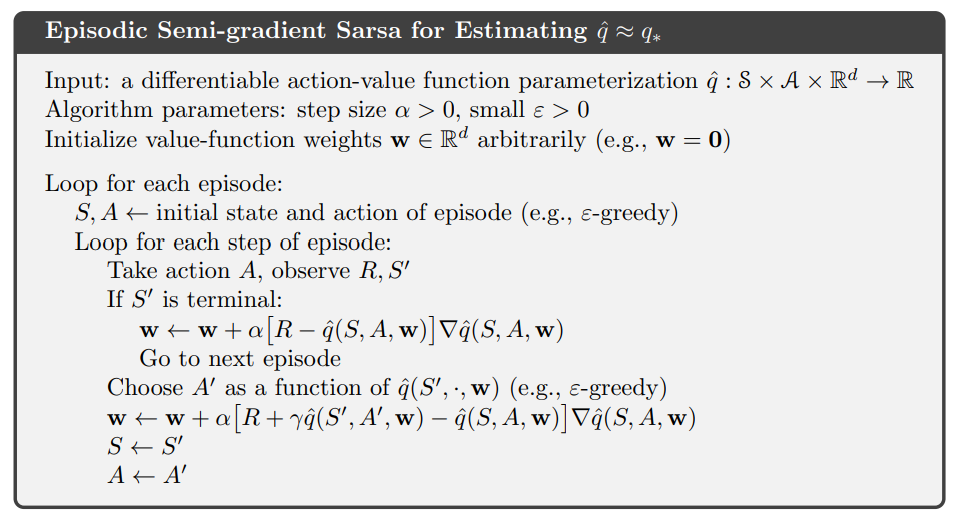

# Create Mountain Car Environment

In [1]:
import gym

In [2]:
env = gym.make('MountainCar-v0')

# Get Env Details

<strong>FROM DOCUSTRING</strong>

```

    ### Description
    The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically
    at the bottom of a sinusoidal valley, with the only possible actions being the accelerations
    that can be applied to the car in either direction. The goal of the MDP is to strategically
    accelerate the car to reach the goal state on top of the right hill. There are two versions
    of the mountain car domain in gym: one with discrete actions and one with continuous.
    This version is the one with discrete actions.
    This MDP first appeared in [Andrew Moore's PhD Thesis (1990)](https://www.cl.cam.ac.uk/techreports/UCAM-CL-TR-209.pdf)
    ```
    @TECHREPORT{Moore90efficientmemory-based,
        author = {Andrew William Moore},
        title = {Efficient Memory-based Learning for Robot Control},
        institution = {University of Cambridge},
        year = {1990}
    }
    ```
    ### Observation Space
    The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
    | Num | Observation                          | Min  | Max | Unit         |
    |-----|--------------------------------------|------|-----|--------------|
    | 0   | position of the car along the x-axis | -Inf | Inf | position (m) |
    | 1   | velocity of the car                  | -Inf | Inf | position (m) |
    ### Action Space
    There are 3 discrete deterministic actions:
    | Num | Observation             | Value | Unit         |
    |-----|-------------------------|-------|--------------|
    | 0   | Accelerate to the left  | Inf   | position (m) |
    | 1   | Don't accelerate        | Inf   | position (m) |
    | 2   | Accelerate to the right | Inf   | position (m) |
    ### Transition Dynamics:
    Given an action, the mountain car follows the following transition dynamics:
    *velocity<sub>t+1</sub> = velocity<sub>t</sub> + (action - 1) * force - cos(3 * position<sub>t</sub>) * gravity*
    *position<sub>t+1</sub> = position<sub>t</sub> + velocity<sub>t+1</sub>*
    where force = 0.001 and gravity = 0.0025. The collisions at either end are inelastic with the velocity set to 0
    upon collision with the wall. The position is clipped to the range `[-1.2, 0.6]` and
    velocity is clipped to the range `[-0.07, 0.07]`.
    ### Reward:
    The goal is to reach the flag placed on top of the right hill as quickly as possible, as such the agent is
    penalised with a reward of -1 for each timestep.
    ### Starting State
    The position of the car is assigned a uniform random value in *[-0.6 , -0.4]*.
    The starting velocity of the car is always assigned to 0.
    ### Episode End
    The episode ends if either of the following happens:
    1. Termination: The position of the car is greater than or equal to 0.5 (the goal position on top of the right hill)
    2. Truncation: The length of the episode is 200.
    ### Arguments
    ```
    gym.make('MountainCar-v0')
    ```
    ### Version History
    * v0: Initial versions release (1.0.0)
    
```

In [3]:
print(env.action_space)

Discrete(3)


In [4]:
env.seed(42)
obs = env.reset()

print(obs)

[-0.52517132  0.        ]


# Set Params

In [5]:
alpha = 0.30
epsilon = 0.90
gamma = 1.0

actions = [0,1,2]
count_actions = len(actions)

velocity_range = [-0.07, 0.07]
location_range = [-1.2, 0.6]

min_env = [location_range[0], velocity_range[0]]
max_env = [location_range[1], velocity_range[1]]

# Some Functions

In [6]:
"""
Tile Coding Software version 3.0beta
by Rich Sutton
based on a program created by Steph Schaeffer and others
External documentation and recommendations on the use of this code is available in the 
reinforcement learning textbook by Sutton and Barto, and on the web.
These need to be understood before this code is.

This software is for Python 3 or more.

This is an implementation of grid-style tile codings, based originally on
the UNH CMAC code (see http://www.ece.unh.edu/robots/cmac.htm), but by now highly changed. 
Here we provide a function, "tiles", that maps floating and integer
variables to a list of tiles, and a second function "tiles-wrap" that does the same while
wrapping some floats to provided widths (the lower wrap value is always 0).

The float variables will be gridded at unit intervals, so generalization
will be by approximately 1 in each direction, and any scaling will have 
to be done externally before calling tiles.

Num-tilings should be a power of 2, e.g., 16. To make the offsetting work properly, it should
also be greater than or equal to four times the number of floats.

The first argument is either an index hash table of a given size (created by (make-iht size)), 
an integer "size" (range of the indices from 0), or nil (for testing, indicating that the tile 
coordinates are to be returned without being converted to indices).
"""

basehash = hash

class IHT:
    "Structure to handle collisions"
    def __init__(self, sizeval):
        self.size = sizeval                        
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        "Prepares a string for printing whenever this object is printed"
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)
    
    def fullp (self):
        return len(self.dictionary) >= self.size
    
    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

def tileswrap (ihtORsize, numtilings, floats, wrapwidths, ints=[], readonly=False):
    """returns num-tilings tile indices corresponding to the floats and ints, wrapping some floats"""
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q, width in zip_longest(qfloats, wrapwidths):
            c = (q + b%numtilings) // numtilings
            coords.append(c%width if width else c)
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [7]:
import numpy as np

class sarsa_agent:
    """ 
    class to control the sarsa agent
    env is the ai gym environment used
    actions is the action space as a list
    q_hat is the function approximator used
    alpha is the learning rate
    epsilon is the proportion of times greedy actions are taken
    gamma is the discount factor
    num_ep is the number of episodes to use
    
    """
    def __init__(self, env, actions, q_hat, epsilon, gamma, num_ep):
        self.env = env
        self.actions = actions
        self.q_hat = q_hat
        self.epsilon = epsilon
        self.gamma = gamma
        self.num_ep = num_ep            

    def policy(self, state):
        """
        select action to take

        """
        #print(state)
        #print([self.q_hat.predict(state, act) for act in self.actions])
        if np.random.rand() < self.epsilon:
            #get max action
            action = np.argmax([self.q_hat.predict(state, act) for act in self.actions])
        else:
            #select non max action
            action = np.random.choice(self.actions)
        return action

    def run_episodes(self):
        """
        run thru num_episodes to improve q_hat

        """
        for i in range(self.num_ep):
            if i%250 == 0:
                print("episode :", i)
            #reset env
            obs = self.env.reset()
            #pick first action
            action = self.policy(obs)

        

            #loop exit controller
            finished = 0
            #enter loop till finished
            while not finished:
                
                obs1, reward, done, info = self.env.step(action)
                    
                if done:
                    #update function using (reward - q_hat.predict(obs, action))
                    target = reward
                    self.q_hat.update(obs, action, target)
                    finished = 1
                    if i%250 == 0:
                        print(obs, reward, done, info)
                        print("target", target)
                    
                else:
                    #get next action
                    action1 = self.policy(obs1)                  
                    #update function using (reward + gamma * q_hat.predict(obs1, action1) - q_hat.predict(obs, action))
                    target = (reward + (self.gamma * self.q_hat.predict(obs1, action1)))
                    self.q_hat.update(obs, action, target)
                    #recycle next items to current items and go back to top of the loop for steps in episode
                    obs = obs1                  
                    action = action1             
                
         

In [8]:
import numpy as np


class q_hat_class:
    """
    this is our linear function approximator
    hark back to the example given above from sutton's own site for guidance
    
    """
    def __init__(self, num_tilings, min_env, max_env, count_actions, alpha, weight_init):
        
        if len(min_env) != len(max_env):
            print("min and max env are not same size!")
            return None
        
        self.num_tilings = num_tilings
        self.count_actions = count_actions
        self.dimensions = len(min_env)
        self.min_env = np.array(min_env)
        self.max_env = np.array(max_env)
        self.scales = self.num_tilings / (self.max_env - self.min_env)
        total_tiles = (self.num_tilings+1)**self.dimensions * self.num_tilings * self.count_actions
        
        self.iht = IHT(total_tiles)
        self.weights = np.zeros(total_tiles) + weight_init / num_tilings
        
        self.alpha = alpha / self.num_tilings

    def predict(self, state, action):
        assert len(obs) == self.dimensions
        assert np.isscalar(action)
        
        #scale state
        scaled_state = np.multiply(self.scales, state)
        
        #get tiles
        current_tiles = tiles(self.iht, self.num_tilings,scaled_state, [action])
        #print(current_tiles)
        
        #get prediction
        prediction = np.sum(self.weights[current_tiles])  
        
        return prediction
    
    def update(self, state, action, target):
        assert len(obs) == self.dimensions
        assert np.isscalar(action)
        assert np.isscalar(target)
        
        #scale state
        scaled_state = np.multiply(self.scales, state)
        
        #get tiles
        current_tiles = tiles(self.iht, self.num_tilings, scaled_state, [action])  
        
        #get prediction
        prediction = np.sum(self.weights[current_tiles])  
        
        diff = self.alpha * (target - prediction)
        
        #adjust weights
        self.weights[current_tiles] += diff       


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

def plot_q_max_3d(q_arr, min_env, max_env, color='#1f77b4', alpha=1.,
                  title='', labels=['x','y','z'], axis=None):
    """Plot 3D wireframe
    
    Params:
        q_arr     - 2d array with dim: [state_x, state_y]
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
        color     - plot color
        alpha     - plot transparency
        labels    - string array [label_x, label_y, label_z], len=3, empty str to omit
        axis      - axis to plot to, if None create new figure
    """
    q_max = -1 * np.max(q_arr, axis=-1)  # calc max and inverse
    
    x_min, x_max = min_env[0], max_env[0]
    y_min, y_max = min_env[1], max_env[1]
    x_space = np.linspace(x_min, x_max, num=q_max.shape[0])
    y_space = np.linspace(y_min, y_max, num=q_max.shape[1])
    Y, X = np.meshgrid(y_space, x_space)
    
    if axis is None:
        fig = plt.figure()
        axis = fig.add_subplot(111, projection='3d')

    axis.plot_wireframe(X, Y, q_max, color=color, alpha=alpha)
    axis.set_xlabel(labels[0])
    axis.set_ylabel(labels[1])
    axis.set_zlabel(labels[2])
    axis.set_xticks([x_min, x_max])
    axis.set_yticks([y_min, y_max])
    axis.set_title(title)
    
    axis.view_init(40, -70)

    
    
def eval_state_action_space(q_hat, min_env, max_env, actions, x_split, y_split ):
    """Evaluate 2d Q-function on area and return as 3d array
    
    Params:
        q_hat     - function approximator with method: q_hat.eval(state, action) -> float
        env       - environment with members:
                      st_low - state space low boundry e.g. [-1.2, -0.07]
                      st_high - state space high boundry
                      act_space - action space, e.g. [0, 1, 2]
        split     - number of data points in each dimensions, e.g. [20, 20]
    """
    x_min, x_max = min_env[0], max_env[0]
    y_min, y_max = min_env[1], max_env[1]
    
    
    q_arr = np.zeros([x_split, y_split, len(actions)])

    for pi, pos in enumerate(np.linspace(x_min, x_max, x_split)):
        for vi, vel in enumerate(np.linspace(y_min, y_max, y_split)):
            for act in actions:
                q_arr[pi, vi, act] = q_hat.predict(state=[pos, vel], action=act)
                
    return q_arr

In [10]:
q_hat = q_hat_class(8, min_env, max_env, len(actions), alpha, 0)

In [11]:
num_ep = 1000
agent = sarsa_agent(env, actions, q_hat, epsilon, gamma, num_ep)

In [12]:
agent.run_episodes()

episode : 0
[-0.28762109  0.00579339] -1.0 True {'TimeLimit.truncated': True}
target -1.0
episode : 250
[0.4659418  0.03851347] -1.0 True {}
target -1.0
episode : 500
[0.48157168 0.02362759] -1.0 True {}
target -1.0
episode : 750
[0.48995632 0.03159465] -1.0 True {}
target -1.0


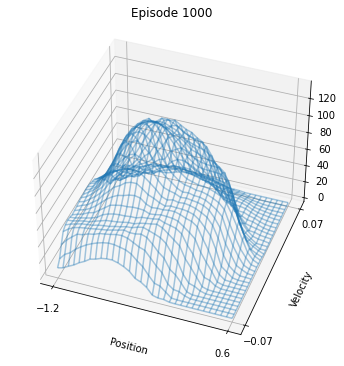

In [13]:
fig = plt.figure(figsize=[20,20])
ax = fig.add_subplot(232, projection='3d')

labels = ['Position', 'Velocity', '']

q_arr = eval_state_action_space(q_hat, min_env, max_env, actions, 32, 32)

plot_q_max_3d(q_arr, min_env, max_env, title='Episode 1000', labels=labels, alpha=.4, axis=ax)